<a href="https://colab.research.google.com/github/babakansari/DeepLearning/blob/master/Assignment_4_Babak_Ansari_ImageGeneratorDCGAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Babak Ansari-Jaberi, 
Deap Learning course at UofT

In [0]:
import os
import time
import keras
import random
import datetime
import numpy as np
from PIL import Image
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D , Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Hyperparameters:

In [0]:
IMAGE_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 50 # For better results increase this value
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 8

In [0]:
def generator(z=(NOISE_SIZE,)):
    # 4 x 4 x 512
    input_layer = Input(z)
    hid = Dense(4*4*512, activation='relu', name ="Dense")(input_layer)    
    hid = LeakyReLU(alpha=0.2)(hid)
    hid = Reshape((4, 4, 512))(hid)

    # 4x4x512 -> 8x8x512
    hid = Conv2DTranspose(512, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv1")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv1")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv1_out")(hid)
    

    # 8x8x512 -> 16x16x256
    hid = Conv2DTranspose(256, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv2")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv2")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv2_out")(hid)
    
    
    # 16x16x256 -> 32x32x128
    hid = Conv2DTranspose(128, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv3")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv3")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv3_out")(hid)    
    

    # 32x32x128 -> 64x64x64
    hid = Conv2DTranspose(64, kernel_size=[5,5],
                               strides=[2,2],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="trans_conv4")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_trans_conv4")(hid)
    hid = LeakyReLU(alpha=0.2,name ="trans_conv4_out")(hid)        
    

    # 64x64x64 -> 64x64x3
    hid = Conv2DTranspose(3, kernel_size=[5,5],
                               strides=[1,1],
                               padding="same",
                               kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),name ="logits")(hid)
  
    out = Activation("tanh", name ="out")(hid)
    
    model = Model(inputs=input_layer, outputs=out)
    model.summary()
  
    return model

In [0]:

def discriminator(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)):
  # 64x64x3 -> 32x32x32
    input_layer = Input(input_shape)
    hid = Conv2D(filters=32,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv1")(input_layer)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm1")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv1_out")(hid)    
    
    # 32x32x32-> 16x16x64 
    hid = Conv2D(filters=64,
                        kernel_size=[5,5],
                        strides=[2,2],
                        padding="same",
                        kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                        name = "conv2")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm2")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv2_out")(hid) 
    
    # 16x16x64  -> 8x8x128  
    hid = Conv2D(filters=128,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv3")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm3")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv3_out")(hid)
    
    # 8x8x128 -> 8x8x256
    hid = Conv2D(filters=256,
                    kernel_size=[5,5],
                    strides=[1,1],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv4")(hid)
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm4")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv4_out")(hid)
    

    # 8x8x256 -> 4x4x512
    hid = Conv2D(filters=512,
                    kernel_size=[5,5],
                    strides=[2,2],
                    padding="same",
                    kernel_initializer= keras.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                    name = "conv5")(hid)  
    hid = BatchNormalization(momentum=0.9, epsilon=EPSILON, name="batch_norm5")(hid)
    hid = LeakyReLU(alpha=0.2, name="conv5_out")(hid)
    
    hid = Flatten(name = "flatten")(hid)

    out = Dense(1, activation='sigmoid', name = "ligit")(hid)
    model = Model(inputs= input_layer, outputs=out)

    model.summary()

    return model

Discriminator

In [0]:
d = discriminator((IMAGE_SIZE, IMAGE_SIZE,3))
d.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR_D, beta_1=BETA1),metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        2432      
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_out (LeakyReLU)        (None, 32, 32, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
conv2_out (LeakyReLU)        (None, 16, 16, 64)        0   

Only train the generator

In [0]:
d.trainable = False

Generator:

In [0]:
g = generator((NOISE_SIZE,))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
trans_conv1 (Conv2DTranspose (None, 8, 8, 512)         6554112   
_________________________________________________________________
batch_trans_conv1 (BatchNorm (None, 8, 8, 512)         2048      
_________________________________________________________________
trans_conv1_out (LeakyReLU)  (None, 8, 8, 512)         0   

The discriminator takes generated images as input and determines validity


In [0]:

gan_input = Input(shape=(NOISE_SIZE,))
x = g(gan_input)
gan_out = d(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(loss='binary_crossentropy',optimizer=Adam(lr=LR_G, beta_1=BETA1))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_3 (Model)              (None, 64, 64, 3)         11691395  
_________________________________________________________________
model_2 (Model)              (None, 1)                 4367553   
Total params: 16,058,948
Trainable params: 11,689,475
Non-trainable params: 4,369,473
_________________________________________________________________


In [0]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)

    plt.show()
    plt.close()

In [0]:


def test(input_z, epoch):
    samples = g.predict(input_z[:SAMPLES_TO_SHOW])
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)



In [0]:
def summarize_epoch(d_losses, g_losses , data_shape, epoch, duration, input_z):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(input_z, epoch)

In [0]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return np.array(batches)

In [0]:
# Paths
INPUT_DATA_DIR = "simpsons-faces/cropped/" # Path to the folder with input images. For more info check simspons_dataset.txt
OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Training:

Input: (9877, 64, 64, 3)


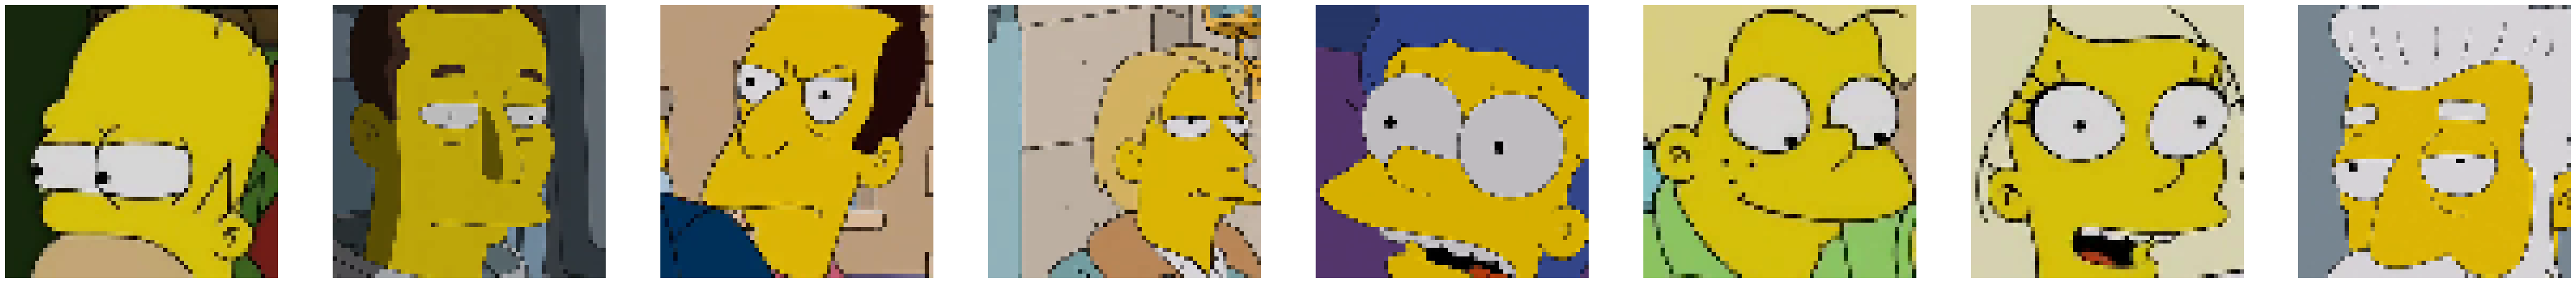

In [0]:
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))
np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)



Training

Training Starts!
Epoch 1/50 
Duration: 978.87105 
D Loss: 1.36481 
G Loss: 2.79073


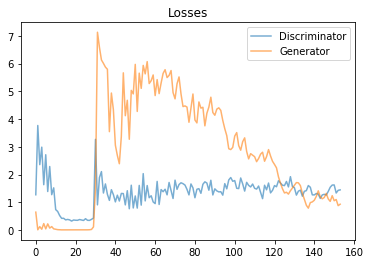

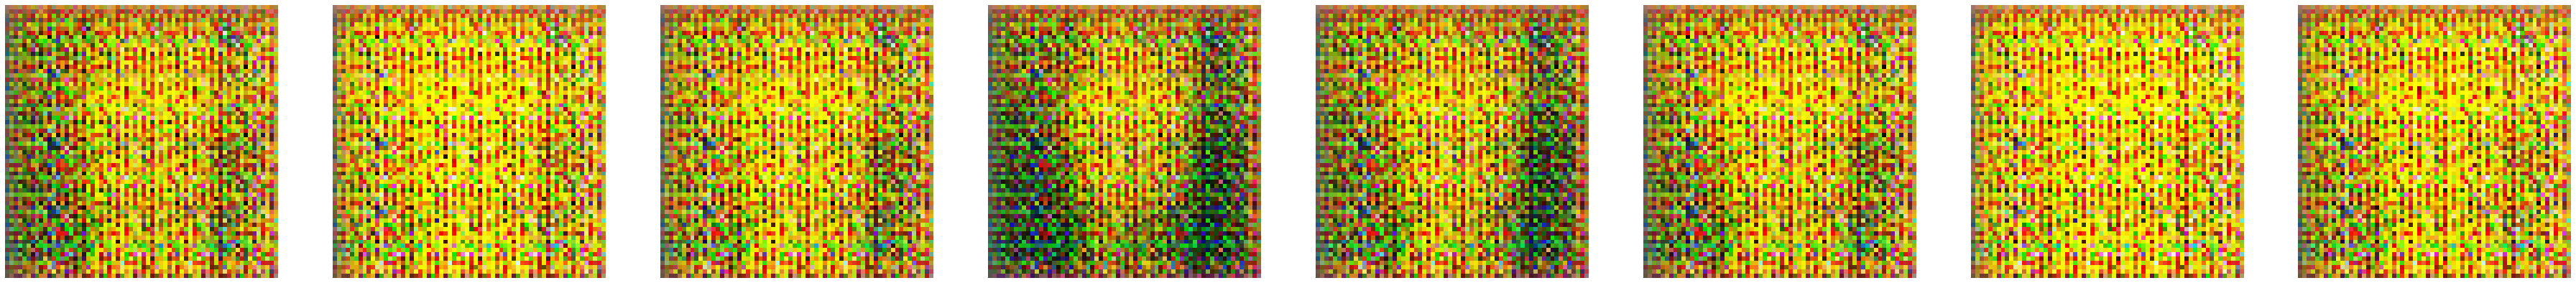

In [0]:
print("Training Starts!")

warnings.filterwarnings("ignore")

d_losses = []
g_losses = []
cum_d_loss = 0
cum_g_loss = 0

for epoch in range(EPOCHS):
    epoch += 1
    start_time = time.time()
    
    for batch_images in get_batches(input_images):
        
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        # We use same labels for generated images as in the real training batch
        generated_images = g.predict(noise_data)
        
        noise_prop = 0.05 # Randomly flip 5% of targets
        real_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(real_labels)), size=int(noise_prop*len(real_labels)))
        real_labels[flipped_idx] = 1 - real_labels[flipped_idx]
        
        # Train discriminator on real data
        d_loss_real = d.train_on_batch(batch_images, real_labels)


        # Prepare labels for generated data
        fake_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(fake_labels)), size=int(noise_prop*len(fake_labels)))
        fake_labels[flipped_idx] = 1 - fake_labels[flipped_idx]
        
        # Train discriminator on generated data
        d_loss_fake = d.train_on_batch(generated_images, fake_labels)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        cum_d_loss += d_loss
        d_losses.append(d_loss[0])
        
        
        # Train generator
        noise_data = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_SIZE))
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        cum_g_loss += g_loss
        g_losses.append(g_loss)
        
    if epoch > 0 and epoch % 20 == 0 :
        print("saving model")
        d.save_weights("desc-simposon-model.h5-" + str(epoch))
        gan.save_weights("gan-simposon-model.h5-" + str(epoch))
        
    # Plot the progress
    summarize_epoch(d_losses, g_losses, input_images.shape, epoch, time.time()-start_time, noise_data)